##### Summary
##### 矢野浩一, "粒子フィルタの基礎と応用：フィルタ・平滑化・パラメータ推定", 日本統計学会誌, 2014-09 より、P198~201の実装。

※層化サンプリングの意義がまだ分かっていない、そもそもランダムだとソーティングが必要みたく書いてあるのが良く分からない（以下ではソーティングしていない、日本語論文もソーティングしていない）

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from numpy.random import *

#### 1. データ生成

以下は、システム方程式と観測方程式、初期値、対象ステップ数から、真の状態変数ベクトルと観測値ベクトルを生成するメソッド。

In [2]:
#データ生成メソッド
def DataGenerate(system_equation, obs_equation, T, x_0):

    x = np.empty(T+1)
    y = np.empty(T+1)
    x[0] = x_0
    y[0] = None

    for i in range(1,T+1):
        x[i] = system_equation(x[i-1], i)
        y[i] = obs_equation(x[i])

    return x, y

#### 2. モンテカルロ法を用いた計算

以下は、システム方程式（予測分布の発生式）と観測方程式を元にして、フィルタリングシミュレーションを行う。

In [3]:
#1step
def Step(system_equation_gen, obs_L, x_samples, y_t, t):

    m = len(x_samples)
    
    #RandomGenerate
    x_samples = system_equation_gen(x_samples, t)
    
    #likelihood
    y_t_array = np.full(m, y_t)
    w_t = obs_L(x_samples, y_t_array)

    #Resampling -- with high speed
    new_samples = np.empty(m)
    u_t = rand(m)
    w_t = w_t / np.sum(w_t)
    w_t = w_t.cumsum()
    
    for i in range(m):
        u = u_t[i]
        try:
            j = np.where(w_t > u)[0][0]
        except:
            print(u,"is a unexpected number")
            j = m - 1
            
        new_samples[i] = x_samples[j]

    return new_samples



#Total Calculation
def Filtering(system_equation_gen, obs_L, y_t, x_0, Per_CI, T, estimation_method = 'average'):

    #outputの準備
    est_x = np.full(T+1, 100, dtype=np.float)
    lower_CI = np.full(T+1, 100, dtype=np.float)
    upper_CI = np.full(T+1, 100, dtype=np.float)
    low = int(len(x_0) * (1- Per_CI) / 2)
    high = int(len(x_0) - low)
    
    #初期値
    x_samples = x_0
    x_samples = np.sort(x_samples)
    if estimation_method == 'average':
        est_x[0] = np.average(x_samples)
    elif estimation_method == 'median':
        est_x[0] = np.median(x_samples)
    else:
        print("estimation_method", estimation_method, ' is incorrect.')
        sys.exit()
        
        
    lower_CI[0] = x_samples[low]
    upper_CI[0] = x_samples[high]
    
    #Main calc
    for i in range(1, T+1):
        
        print("Calculating ", i, " Step........")
        x_samples = Step(system_equation_gen, obs_L, x_samples, y_t[i], i)
        
        #平均/中央値とCIの計算
        x_samples = np.sort(x_samples)
        
        if estimation_method == 'average':
            tmp_est = np.average(x_samples)
        elif estimation_method == 'median':
            tmp_est = np.median(x_samples)
        
        tmp_low = x_samples[low]
        tmp_upper = x_samples[high]
        print("Est_x: ",tmp_est , "  lower_CI:", tmp_low, " upper_CI:", tmp_upper)
        
        est_x[i] = tmp_est
        lower_CI[i] = tmp_low
        upper_CI[i] = tmp_upper
    
    return est_x, lower_CI, upper_CI

#### 3. 実計算

In [4]:
#まずは線形・ガウス型状態空間モデル。

#システム方程式、観測方程式は以下。
def system_equation_1(x, t):
    v = normal(0,1,1)
    return x + v
def obs_equation_1(x):
    e = normal(0,0.5)
    return x + e

#予測分布の発生式
def system_equation_gen_1(x_samples, t):
    v = normal(0,1,len(x_samples))
    return x_samples + v

#尤度の計算式
def obs_L_1(x,y):
    t = y-x
    return (1/np.sqrt(2*np.pi*0.25))*np.exp(-1 * (t**2) / 0.5)

#初期値x_0を0として、T=50までの真の状態x_tと観測値y_tを発生させる
x, y = DataGenerate(system_equation_1, obs_equation_1, 50, 0)

In [13]:
#計算を行う
x_0 = np.zeros(10000)
est, lower, upper= Filtering(system_equation_gen_1, obs_L_1, y, x_0, 0.95, 50)

Calculating  1  Step........
Est_x:  -0.0728508210404   lower_CI: -0.959647320397  upper_CI: 0.79226767499
Calculating  2  Step........
Est_x:  -0.216920112175   lower_CI: -1.08975799466  upper_CI: 0.659291366394
Calculating  3  Step........
Est_x:  0.180019394239   lower_CI: -0.702117990833  upper_CI: 1.08092302627
Calculating  4  Step........
Est_x:  0.55525027568   lower_CI: -0.326779190075  upper_CI: 1.45829987804
Calculating  5  Step........
Est_x:  0.355268612916   lower_CI: -0.546793122439  upper_CI: 1.239978798
Calculating  6  Step........
Est_x:  0.561807005415   lower_CI: -0.340911855469  upper_CI: 1.47832691012
Calculating  7  Step........
Est_x:  1.10415867792   lower_CI: 0.236745707  upper_CI: 1.98796853325
Calculating  8  Step........
Est_x:  0.257544956277   lower_CI: -0.644502663408  upper_CI: 1.15911183606
Calculating  9  Step........
Est_x:  -1.4685122666   lower_CI: -2.31939047705  upper_CI: -0.595829143715
Calculating  10  Step........
Est_x:  -2.02424874437   lower

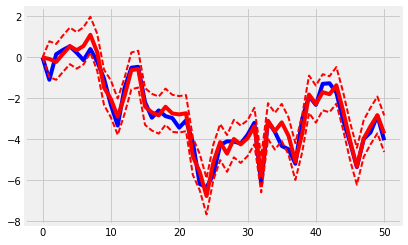

In [21]:
plt.plot(x, color = 'blue')
plt.plot(est, color = 'red')
plt.plot(upper,'--', color = 'red', linewidth=2)
plt.plot(lower, '--', color = 'red', linewidth=2)

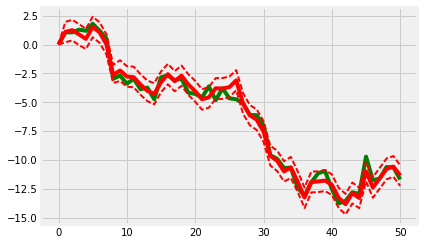

In [52]:
plt.plot(x, color = 'green')
plt.plot(est, color = 'red')
plt.plot(upper,'--', color = 'red', linewidth=2)
plt.plot(lower, '--', color = 'red', linewidth=2)

In [70]:
#次に、非線形・ガウス型状態空間モデル。（Kitagawa 1993, 1996）

#システム方程式、観測方程式は以下。
def system_equation_2(x, t):
    v = normal(0,1)
    return (1/2) * x + 25 * x / (1 + x **2) + 8 * np.cos(1.2 * t) + v
def obs_equation_2(x):
    e = normal(0,10)
    return (1/2) * (x**2) + e

#予測分布の発生式
def system_equation_gen_2(x_samples, t):
    v = normal(0,1,len(x_samples))
    t_array = np.ones(len(x_samples))
    t_array = t * t_array
    return (1/2) * x_samples + 25 * x_samples / (1 + x_samples **2) + 8 * np.cos(1.2 * t_array) + v

#尤度の計算式
def obs_L_2(x,y):
    t = y - (1/2) * (x**2)
    return (1/np.sqrt(2*np.pi*10))*np.exp(-1 * (t**2) / 20)

#初期値x_0を0として、T=100までの真の状態x_tと観測値y_tを発生させる
x, y = DataGenerate(system_equation_2, obs_equation_2, 100, 0)

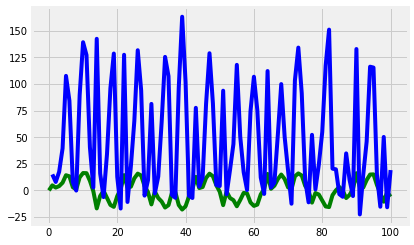

In [71]:
plt.plot(x, color = 'green')
plt.plot(y, color = 'blue')

In [72]:
#計算を行う
x_0 = np.zeros(10000)
est, lower, upper= Filtering(system_equation_gen_2, obs_L_2, y, x_0, 0.95, 100)

Calculating  1  Step........
Est_x:  4.66060313213   lower_CI: 3.35224770951  upper_CI: 5.7965887733
Calculating  2  Step........
Est_x:  2.60342955533   lower_CI: 0.288197448509  upper_CI: 4.2677881805
Calculating  3  Step........
Est_x:  5.45108646021   lower_CI: 4.20108512114  upper_CI: 6.64902635606
Calculating  4  Step........
Est_x:  8.72989521904   lower_CI: 8.05679351155  upper_CI: 9.39783238164
Calculating  5  Step........
Est_x:  14.6713080953   lower_CI: 14.2598519963  upper_CI: 15.0853498754
Calculating  6  Step........
Est_x:  13.0299180617   lower_CI: 12.568939518  upper_CI: 13.4951477398
Calculating  7  Step........
Est_x:  3.98392725466   lower_CI: 2.67789303659  upper_CI: 5.11365545318
Calculating  8  Step........
Est_x:  0.0774953743194   lower_CI: -1.96134764112  upper_CI: 2.14389191996
Calculating  9  Step........
Est_x:  -10.711455255   lower_CI: -13.8370990648  upper_CI: 13.3806774457
Calculating  10  Step........
Est_x:  16.6491868294   lower_CI: 16.274299063  up

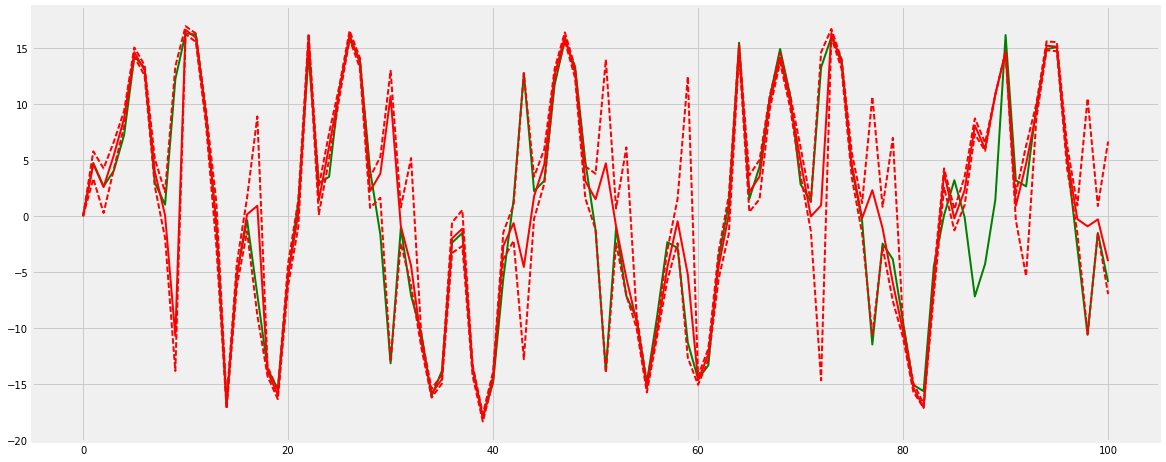

In [73]:
plt.figure(figsize=(18,8))
plt.plot(x, color = 'green',linewidth=2)
plt.plot(est, color = 'red',linewidth=2)
plt.plot(upper,'--', color = 'red', linewidth=2)
plt.plot(lower, '--', color = 'red', linewidth=2)

In [78]:
#確率的ボラティリティモデル（Stochastic Volatility Model, SV）

#システム方程式、観測方程式は以下。
def system_equation_3(x, t):
    v = normal(0,0.5)
    return 0.98 * x + v
def obs_equation_3(x):
    e = normal(0,1)
    return e * np.exp(x/2)

#予測分布の発生式
def system_equation_gen_3(x_samples, t):
    v = normal(0,0.5,len(x_samples))
    return 0.98 * x_samples + v

#尤度の計算式
def obs_L_3(x,y):
    t = y / np.exp(x/2)
    return (1/np.sqrt(2*np.pi))*np.exp(-1 * (t**2) / 2)


#初期値x_0を0として、T=200までの真の状態x_tと観測値y_tを発生させる
x, y = DataGenerate(system_equation_3, obs_equation_3, 200, 0)

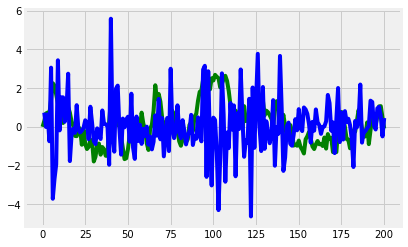

In [79]:
plt.plot(x, color = 'green')
plt.plot(y, color = 'blue')

In [76]:
#計算を行う
x_0 = np.zeros(10000)
est, lower, upper= Filtering(system_equation_gen_3, obs_L_3, y, x_0, 0.95, 200, estimation_method='median')

Calculating  1  Step........
Est_x:  0.0760508393672   lower_CI: -0.829249610232  upper_CI: 1.04030102406
Calculating  2  Step........
Est_x:  0.0707441898819   lower_CI: -1.23824571579  upper_CI: 1.43387443069
Calculating  3  Step........
Est_x:  0.505484156406   lower_CI: -0.773089834881  upper_CI: 1.92506555563
Calculating  4  Step........
Est_x:  0.592559734728   lower_CI: -0.937382119157  upper_CI: 2.22258996312
Calculating  5  Step........
Est_x:  0.725813163839   lower_CI: -0.914628488381  upper_CI: 2.50047986489
Calculating  6  Step........
Est_x:  1.28556525294   lower_CI: -0.187874066434  upper_CI: 3.04932962695
Calculating  7  Step........
Est_x:  1.31601153253   lower_CI: -0.352164775602  upper_CI: 3.35637809164
Calculating  8  Step........
Est_x:  1.37443733631   lower_CI: -0.446958427117  upper_CI: 3.48650618981
Calculating  9  Step........
Est_x:  1.54250942941   lower_CI: -0.303476267109  upper_CI: 3.79993571795
Calculating  10  Step........
Est_x:  1.52216373552   lowe

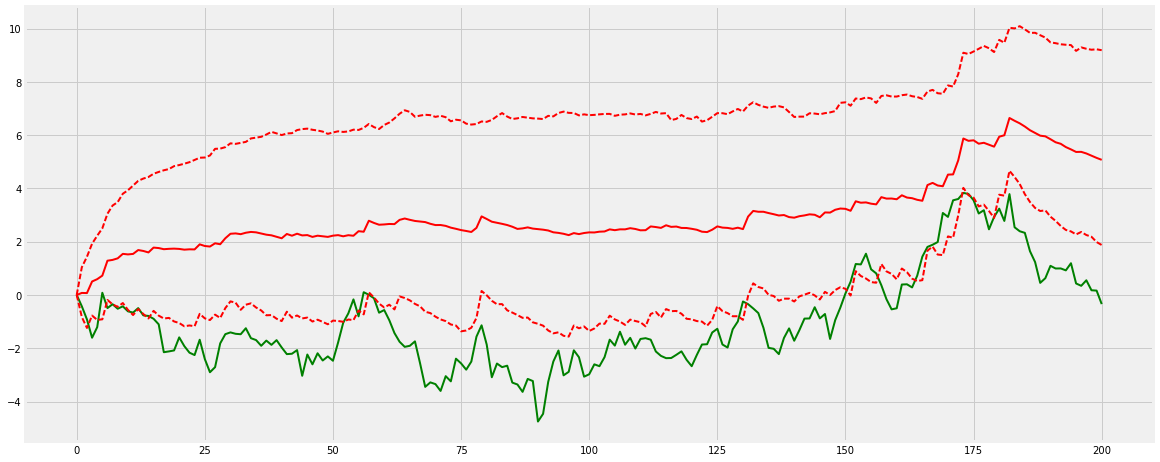

In [77]:
plt.figure(figsize=(18,8))
plt.plot(x, color = 'green',linewidth=2)
plt.plot(est, color = 'red',linewidth=2)
plt.plot(upper,'--', color = 'red', linewidth=2)
plt.plot(lower, '--', color = 'red', linewidth=2)